In [73]:
import os
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
import seaborn as sns

In [64]:
import matplotlib.colors as mcolors
colors = [(0, 0, 0), (1, 1, 0)]  # Black -> Yellow
black_to_yellow = mcolors.LinearSegmentedColormap.from_list('black_to_yellow', colors)

def plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, track_id_col='track_id', cell_id_to_color=None):
    fig, ax = plt.subplots(2, 1, figsize=(40, 10))

    kymograph_shape = phase_kymograph.shape
    combined_mask = _create_combined_mask(full_region_df, kymograph_shape)
    
    masked_phase_kymograph = phase_kymograph * combined_mask
    masked_fluor_kymograph = fluor_kymograph * combined_mask
    
    ax[0].imshow(masked_phase_kymograph, cmap='grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(masked_fluor_kymograph, cmap= black_to_yellow)
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames", fontsize = 20)
    plt.tight_layout()


def _create_combined_mask(full_region_df, kymograph_shape):
    """
    Creates a single binary mask for the entire kymograph, combining all cell masks.
    """
    combined_mask = np.zeros(kymograph_shape, dtype=bool)
    for _, region_props in full_region_df.iterrows():
        # Check if the 'coords' column exists and is not empty
        if 'coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0:
            cell_pixel_coords = np.array(region_props['coords'])
            rows = cell_pixel_coords[:, 0]
            cols = cell_pixel_coords[:, 1]
            combined_mask[rows, cols] = True
    return combined_mask


def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None, cell_id_to_color=None):
    default_cell_contour_color = 'gray'
    text_color = 'white'
    text_offset_x = 5
    text_offset_y = 0

    all_contours_segments = []
    all_contour_colors = []
    all_text_params = []

    for _, region_props in full_region_df.iterrows():
        if not ('coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0):
            continue
        
        cell_pixel_coords = np.array(region_props['coords'])
        
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)
        
        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)
        
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        temp_mask[relative_rows, relative_cols] = 1
        
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')
        if not contours:
            continue
        
        current_cell_id = region_props[lineage_col] if lineage_col else None
        
        # Determine the color of the cell outline
        current_color = default_cell_contour_color
        if cell_id_to_color and current_cell_id in cell_id_to_color:
            current_color = cell_id_to_color[current_cell_id]
        
        for contour in contours:
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            all_contours_segments.append(np.vstack([global_contour_x, global_contour_y]).T)
            all_contour_colors.append(current_color)

    # Plot the collected data after the loop
    if all_contours_segments:
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=2)
        ax.add_collection(line_collection)
    
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [2]:
train_cells_filename = '/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_tracking_training_data.pkl'
all_lineages_df = pd.read_pickle(train_cells_filename)

In [4]:
all_lineages_df.columns

Index(['label', 'area', 'coords', 'centroid_y', 'centroid_x',
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor', 'time_frame',
       'experiment_name', 'FOV', 'trench_id', 'track_id', 'node_id',
       'ground_truth_lineage', 'gene'],
      dtype='object')

In [190]:
def find_peaks(df: pd.DataFrame, fluor_col = 'intensity_mean_fluor', window = 7) -> pd.DataFrame:
    """
    Detects local fluorescence peaks for each unique experiment, FOV, and trench.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'experiment_name',
                           'FOV', 'trench_id', 'time_frame', and
                           'intensity_mean_fluor' columns.

    Returns:
        pd.DataFrame: The original DataFrame with two new columns:
                      'is_local_peak' and 'peak_score'.
    """
    df_with_peaks = pd.DataFrame()

    # Group the DataFrame by the three specified columns
    group_cols = ['experiment_name', 'FOV', 'trench_id']
    grouped_data = df.groupby(group_cols)

    for name, group in grouped_data:
        # Sort the group by time_frame to ensure rolling window works correctly
        group = group.sort_values('time_frame')
        
        # Calculate the global mean for the current group
        global_mean_fluor = group[fluor_col].mean()

        # Find local peaks using a rolling window of 6 frames
        group['local_max'] = group[fluor_col].rolling(window=window, center=True).max()

        # Check if a point is a local peak
        group['is_local_peak'] = (group[fluor_col] == group['local_max'])

        # Calculate a score based on the difference from the global mean
        group['peak_score'] = group[fluor_col] - global_mean_fluor

        # Append the results to the new DataFrame
        df_with_peaks = pd.concat([df_with_peaks, group])

    # Clean up the temporary 'local_max' column
    df_with_peaks = df_with_peaks.drop(columns=['local_max'])
    
    # Reset the index to avoid duplicates after concatenation
    return df_with_peaks.reset_index(drop=True)

In [198]:
peaks_all_lineages_df = find_peaks(all_lineages_df,  fluor_col = 'intensity_max_fluor')

In [199]:
gene = 'mazF'
gene_df = peaks_all_lineages_df[
    # peaks_all_lineages_df['is_valid_peak'] &
    (peaks_all_lineages_df['gene'] == gene)
    ]

unique_fovs = gene_df[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)
gene_df['time_min'] = gene_df['time_frame']*5 

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_38844/499758046.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_df['time_min'] = gene_df['time_frame']*5


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_38844/1218966302.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


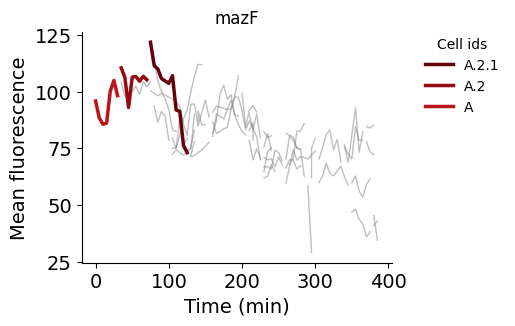

In [200]:
cell_color_dict = {}
for cell_info in unique_fovs:
    exp, fov, trench = cell_info
    
    plt.figure(figsize=(4, 3))
    
    for cell_id in gene_df['ground_truth_lineage'].unique():
        subset = gene_df[gene_df['ground_truth_lineage'] == cell_id].sort_values(by='time_min')
        plt.plot(subset['time_min'], subset['intensity_mean_fluor'], color='gray', alpha=0.5, linewidth=1)
    
    # Plot the specific line to be colored
    local_peaks = gene_df[gene_df['is_local_peak']]
    top_peaks = local_peaks.sort_values(by='peak_score', ascending=False)
    cmap = plt.cm.get_cmap('Reds')
    highlighted_cell_ids =  top_peaks.iloc[:5, :]['ground_truth_lineage'].unique()
    for cell_id_color in highlighted_cell_ids:
        colored_cell = gene_df[gene_df['ground_truth_lineage'] == cell_id_color].sort_values(by='time_min')
        peak_score = top_peaks[top_peaks['ground_truth_lineage'] == cell_id_color]['peak_score'].values[0]
        norm_score = (peak_score - top_peaks['peak_score'].min()) / (top_peaks['peak_score'].max() - top_peaks['peak_score'].min())
        line_color = cmap(norm_score)
        cell_color_dict[cell_id_color] = line_color

        plt.plot(colored_cell['time_min'], colored_cell['intensity_mean_fluor'], linewidth=2.5, color=line_color, label=cell_id_color)
        sns.despine();
        plt.xlabel('Time (min)', fontsize=14)
        plt.ylabel('Mean fluorescence', fontsize=14)
        plt.tick_params(axis='x', labelsize=14)
        plt.tick_params(axis='y', labelsize=14)

    plt.legend(bbox_to_anchor=(1.09, 1), loc='upper left', borderaxespad=0, frameon= False, title = 'Cell ids')
    plt.title(gene)

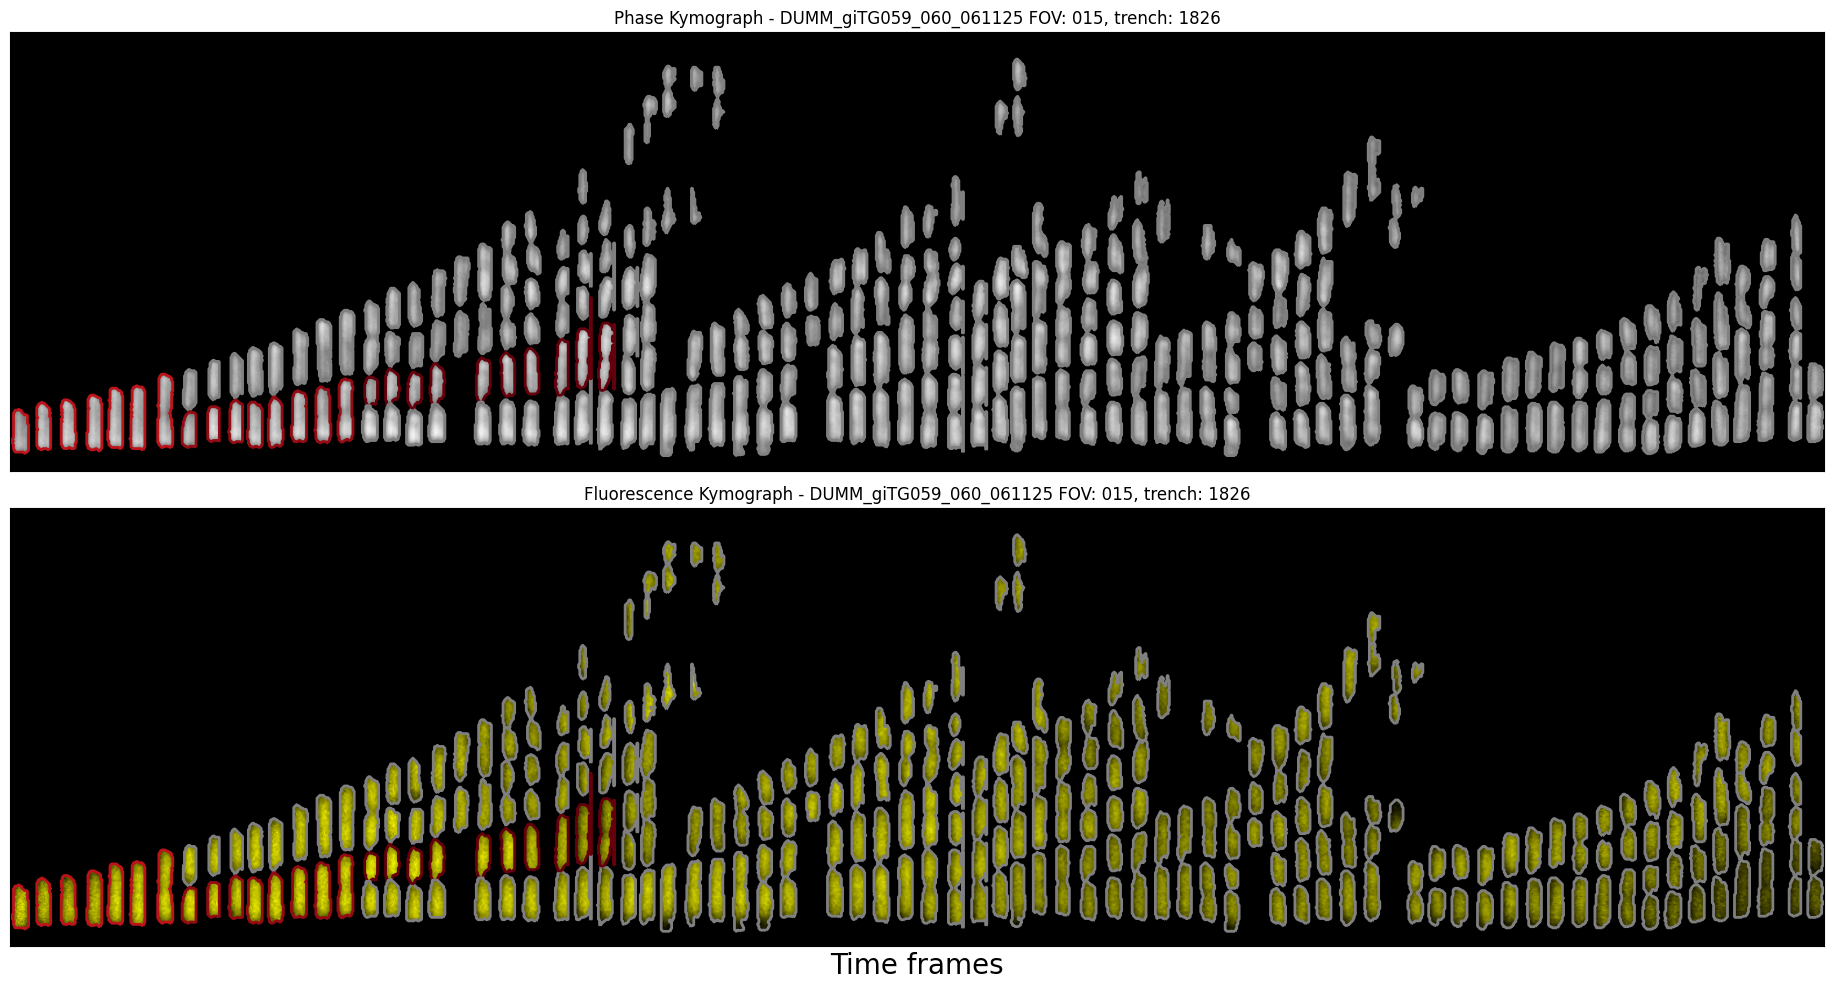

In [201]:
# now highlight the same cells on the kymograph

for cell_info in unique_fovs:
    exp_view, fov_view, trench_view = cell_info

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
    
    
    path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/kymographs/phase/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//kymographs/fluor/{fov_view}_{trench_view}.tif'

    # Check if both Tiff files exist before reading them and proceeding
    if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):
        phase_kymograph = tifffile.imread(path_to_phase_kymograph)
        fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)
        plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, 
                                            gene_df, 
                                            exp_view, fov_view, trench_view, 
                                            track_id_col='ground_truth_lineage', cell_id_to_color=cell_color_dict)

In [129]:
all_lineages_df['time_min'] = all_lineages_df['time_frame']*5 

In [154]:
def detect_fluorescence_bursts_by_group(
    df: pd.DataFrame,
    fluor_col = 'intensity_mean_fluor',
    rolling_window_size: int = 6,
    std_dev_threshold: float = 2
) -> pd.DataFrame:
    """
    Detects fluorescence bursts for each unique experiment, FOV, and trench.

    Args:
        df (pd.DataFrame): The input DataFrame with 'experiment_name', 'FOV',
                           'trench_id', 'time_min', and 'mean_fluorescence' columns.
        rolling_window_size (int): The window size for the rolling filters
                                   (in number of time frames).
        std_dev_threshold (float): The number of standard deviations above the
                                   mean to be considered a significant burst.

    Returns:
        pd.DataFrame: The original DataFrame with new columns for burst detection.
    """
    processed_df_list = []

    # Group the DataFrame by the specified columns
    group_cols = ['experiment_name', 'FOV', 'trench_id']
    grouped_data = df.groupby(group_cols)

    for name, group in grouped_data:
        # Sort the group by time_min to ensure rolling windows work correctly
        group = group.sort_values(by='time_min')

        # Step 1: Baseline Subtraction (Local Baseline)
        group['local_min'] = group[fluor_col].rolling(
            window=rolling_window_size,
            min_periods=1,
            center=True
        ).min()
        
        group['normalized_fluorescence'] = group[fluor_col] - group['local_min']
        group['normalized_fluorescence'] = group['normalized_fluorescence'].clip(lower=0)

        # Step 2: Local Peak Detection
        group['local_max'] = group['normalized_fluorescence'].rolling(
            window=rolling_window_size,
            min_periods=1,
            center=True
        ).max()
        
        group['is_local_peak'] = (group['normalized_fluorescence'] == group['local_max'])

        # Step 3: Statistical Thresholding
        std_dev = group['normalized_fluorescence'].std()
        mean_signal = group['normalized_fluorescence'].mean()
        
        threshold = mean_signal + (std_dev_threshold * std_dev)

        group['is_burst'] = (group['is_local_peak']) & (group['normalized_fluorescence'] > threshold)

        processed_df_list.append(group)

    result_df = pd.concat(processed_df_list).reset_index(drop=True)
    
    # Remove temporary columns
    result_df = result_df.drop(columns=['local_min', 'local_max', 'is_local_peak'])

    return result_df

In [186]:
bursts_all_lineages_df = detect_fluorescence_bursts_by_group(all_lineages_df,
                                                            fluor_col = 'intensity_mean_fluor',
                                                            rolling_window_size = 7,
                                                            std_dev_threshold = 2)

In [187]:
gene = 'mazF'
gene_df = bursts_all_lineages_df[
    (bursts_all_lineages_df['gene'] == gene)
    ]

unique_fovs = gene_df[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_38844/714275766.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


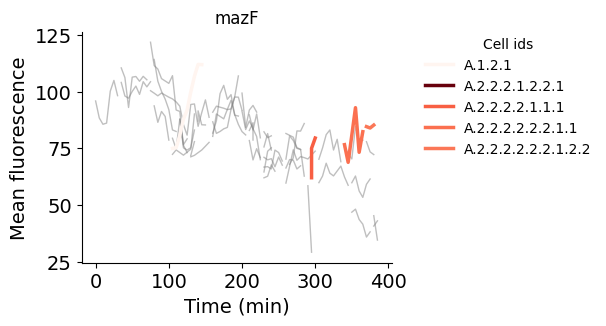

In [188]:
cell_color_dict = {}
for cell_info in unique_fovs:
    exp, fov, trench = cell_info
    
    plt.figure(figsize=(4, 3))
    
    for cell_id in gene_df['ground_truth_lineage'].unique():
        subset = gene_df[gene_df['ground_truth_lineage'] == cell_id].sort_values(by='time_min')
        plt.plot(subset['time_min'], subset['intensity_mean_fluor'], color='gray', alpha=0.5, linewidth=1)
    
    # Plot the specific line to be colored
    local_peaks = gene_df[gene_df['is_burst']]
    cmap = plt.cm.get_cmap('Reds')
    highlighted_cell_ids =  local_peaks['ground_truth_lineage'].unique()
    for cell_id_color in highlighted_cell_ids:
        colored_cell = gene_df[gene_df['ground_truth_lineage'] == cell_id_color].sort_values(by='time_min')
        peak_score = local_peaks[local_peaks['ground_truth_lineage'] == cell_id_color]['normalized_fluorescence'].values[0]
        norm_score = (peak_score - local_peaks['normalized_fluorescence'].min()) / (local_peaks['normalized_fluorescence'].max() - local_peaks['normalized_fluorescence'].min())
        line_color = cmap(norm_score)
        cell_color_dict[cell_id_color] = line_color

        plt.plot(colored_cell['time_min'], colored_cell['intensity_mean_fluor'], linewidth=2.5, color=line_color, label=cell_id_color)
        sns.despine();
        plt.xlabel('Time (min)', fontsize=14)
        plt.ylabel('Mean fluorescence', fontsize=14)
        plt.tick_params(axis='x', labelsize=14)
        plt.tick_params(axis='y', labelsize=14)

    plt.legend(bbox_to_anchor=(1.09, 1), loc='upper left', borderaxespad=0, frameon= False, title = 'Cell ids')
    plt.title(gene)

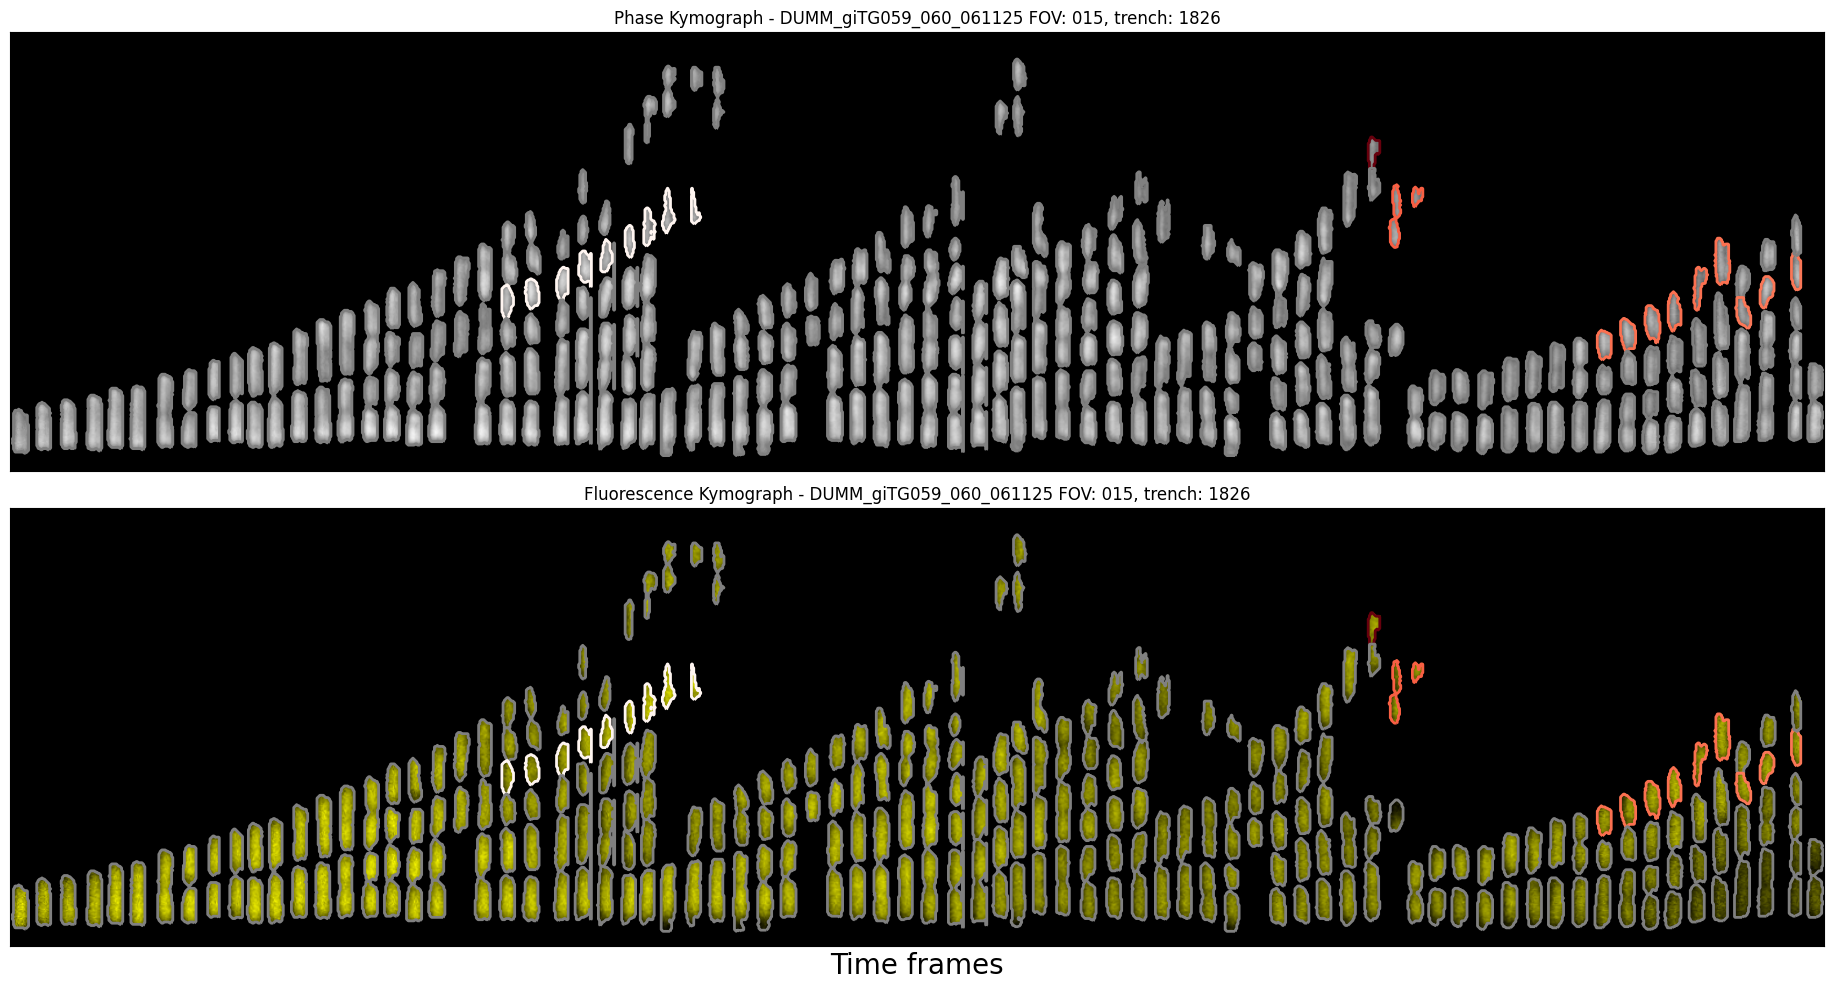

In [189]:
for cell_info in unique_fovs:
    exp_view, fov_view, trench_view = cell_info

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
    
    
    path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/kymographs/phase/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//kymographs/fluor/{fov_view}_{trench_view}.tif'

    # Check if both Tiff files exist before reading them and proceeding
    if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):
        phase_kymograph = tifffile.imread(path_to_phase_kymograph)
        fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

        all_cells_to_view_df = gene_df.copy()
        plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, 
                                            gene_df, 
                                            exp_view, fov_view, trench_view, 
                                            track_id_col='ground_truth_lineage', cell_id_to_color=cell_color_dict)